In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from simfinmodel import *

# Decoupling fundamentals

Moving from fundamental to index means that the relative weight of MT and MR strategies increases. If all fundamental money move to index tracking, it mean that the marginal price setters are only MT and MR strategies, market stability will depend on the relative weighting between MT and MR.

There are many questions at play

1. **Instability**: You are correct saying that this does not have to lead to an explosive system, but the most important moderating force has weakened dramatically. The system could go instable in some situations depending on the relative weighting between different trading strategies or due to the introduction of new trading strategies.
2. **Dynamics**: If there is a disconnect between fundamental value of a stock and the valuation on the market, then that will lead to another dynamics on the financial markets. In the old days (before index funds), the fundamental investors were driving the dynamics.
3. **Flows**: With a large chunk of pension and insurance money invested in index strategies, the flows (in and out of the market) will drive the market (at the beta level). Fear and greed will also drive retail flows in and out of index funds, creating volatility.

When it comes to the conclusions, the key point is not primarily the instability of the market but the change in the dynamics. A decoupling of stock market dynamics from stock fundamentals will have a massive impact on how institutional investors should behave in the short- and medium-term as well as assessing extreme tail risk events. The most extreme case of decoupling is crypto currencies.

## Parameters

In [6]:
NRUNS = 1
parameters = {
    # global parameters
    "n_traders": 5000,
    "ticks": 1000,
    "fundamental_value": 100,
    "std_noise": 0.01,
    "std_vol": 4,
    "max_order_expiration_ticks": 30,
    # trader parameters
    "w_fundamentalists": 0.0,
    "w_momentum": 0.0,
    "w_random": 0.0,
    "w_mean_reversion": 1.0,
    "w_buy_hold": 0.0,
    "spread_max": 0.004087, # from Riordann & Storkenmaier 2012
    # initial values
    "horizon_min": 1,
    "horizon_max": 4,
    "av_return_interval_max": 4,
    "init_spread": (1, 1),
}

## Baseline Monte Carlo Simulations

In [7]:
traders = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects(parameters)
    traders, orderbook = sim_fin_model(traders, orderbook, parameters, seed)
    traders.append(traders)
    obs.append(orderbook)

## Dynamics

In [8]:
window = 10
close_price = []
returns = []
autocorr_returns = []
autocorr_abs_returns = []
returns_volatility = []
volume = []
for ob in obs: # record
    # close price
    close_price.append(ob.tick_close_price)
    # returns
    r = pd.Series(np.array(ob.tick_close_price)).pct_change()
    returns.append(r)
    # autocorrelation returns
    ac_r = [r.autocorr(lag=lag) for lag in range(25)]
    autocorr_returns.append(ac_r)
    # autocorrelation absolute returns
    absolute_returns = pd.Series(r).abs()
    autocorr_abs_returns.append([absolute_returns.autocorr(lag=lag) for lag in range(25)])
    # volatility of returns
    roller_returns = r.rolling(window)
    returns_volatility.append(roller_returns.std(ddof=0))
    # volume
    volume.append([sum(volumes) for volumes in ob.transaction_volumes_history])
mc_prices = pd.DataFrame(close_price).transpose()
mc_returns = pd.DataFrame(returns).transpose()
mc_autocorr_returns = pd.DataFrame(autocorr_returns).transpose()
mc_autocorr_abs_returns = pd.DataFrame(autocorr_abs_returns).transpose()
mc_volatility = pd.DataFrame(returns_volatility).transpose()
mc_volume = pd.DataFrame(volume).transpose()

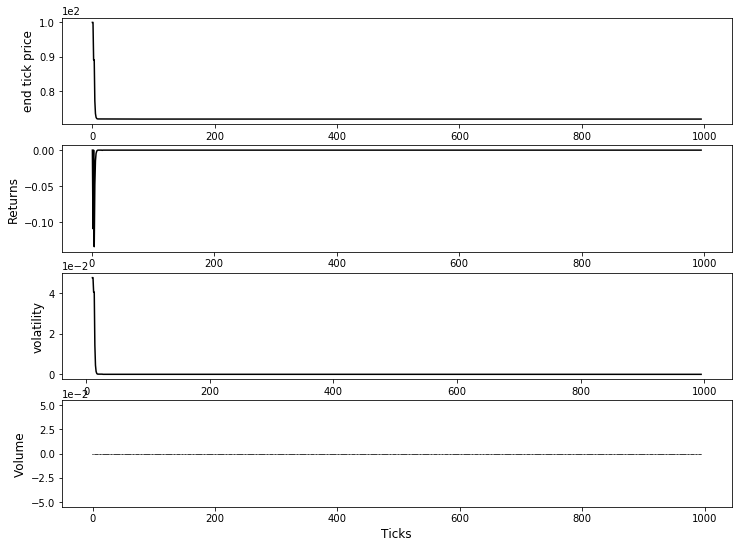

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,9))

ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k-')
ax1.set_ylabel('end tick price', fontsize='12')

ax2.plot(mc_returns.index, mc_returns.mean(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.plot(mc_volatility.index, mc_volatility.mean(axis=1), 'k-')
ax3.set_ylabel('volatility', fontsize='12')

ax4.bar(mc_volume.index, mc_volume.mean(axis=1), color='k', edgecolor='k')
ax4.set_ylabel('Volume', fontsize='12')
ax4.set_xlabel('Ticks', fontsize='12')

for ax in [ax1, ax2, ax3, ax4]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

# Basic stylized facts

* **No autocorrelation** in returns
* **Volatility clustering** (marked by slowly decaying absolute autocorrelation)

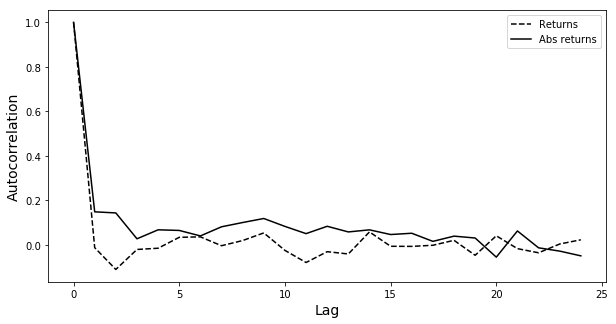

In [37]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='Abs returns')
ax1.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

* **Excess Kurtosis**

In [38]:
mc_prices.mean(axis=1).kurtosis()

-0.42309032060957641

# Experiments